### Installs & Imports

In [ ]:
!pip install --upgrade pip

!pip install emoji langdetect nltk scikit-learn pandas numpy spacy guidedlda simpletransformers \
    seaborn matplotlib pickle5 gensim cython vaderSentiment

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


# System & Utility Libraries
import os
import json
import re
import pickle
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from io import StringIO

# NLTK & NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Spacy NLP
import spacy
from spacy.tokens import Doc

# Scikit-learn & ML Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import svm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Language Detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Emoji Handling
import emoji

# Topic Modeling
import guidedlda

# SimpleTransformers for Deep Learning Models
from simpletransformers.classification import ClassificationModel, ClassificationArgs


ModuleNotFoundError: No module named 'simpletransformers'

# 1. Named Entity Recognition & Classification

### Training & Validation Sets

#### Distribution Analysis

In [ ]:
label_mapping = {
    0: 'O', 1: 'B-CARDINAL', 2: 'B-DATE', 3: 'I-DATE', 4: 'B-PERSON', 5: 'I-PERSON',
    6: 'B-NORP', 7: 'B-GPE', 8: 'I-GPE', 9: 'B-LAW', 10: 'I-LAW', 11: 'B-ORG',
    12: 'I-ORG', 13: 'B-PERCENT', 14: 'I-PERCENT', 15: 'B-ORDINAL', 16: 'B-MONEY',
    17: 'I-MONEY', 18: 'B-WORK_OF_ART', 19: 'I-WORK_OF_ART', 20: 'B-FAC',
    21: 'B-TIME', 22: 'I-CARDINAL', 23: 'B-LOC', 24: 'B-QUANTITY', 25: 'I-QUANTITY',
    26: 'I-NORP', 27: 'I-LOC', 28: 'B-PRODUCT', 29: 'I-TIME', 30: 'B-EVENT',
    31: 'I-EVENT', 32: 'I-FAC', 33: 'B-LANGUAGE', 34: 'I-PRODUCT', 35: 'I-ORDINAL',
    36: 'I-LANGUAGE'
}

In [ ]:
# Training data (merge 5 files together - we use the original four training files and valiadation as training data)
# # a new file called 'merged_word_train_val' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
train_val_files = ["Training Data/NERC Data/Original/train00.json", "Training Data/NERC Data/Original/train01.json", "Training Data/NERC Data/Original/train02.json",
                    "Training Data/NERC Data/Original/train03.json", "Training Data/NERC Data/Original/valid.json"]

output_file = "Training Data/NERC Data/merged_word_train_val.json"

word_instances = []
sentence_id = 0

for file in train_val_files:
    with open(file, "r", encoding="utf-8") as in_file:
        for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")

In [ ]:
# Validation data (we use the original test data as validation data)
# a new file called 'merged_word_test' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
test_file = "Training Data/NERC Data/Original/test.json"
output_file = "Training Data/NERC Data/word_test.json"

word_instances = []
sentence_id = 0

with open(test_file, "r", encoding="utf-8") as in_file:
    for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            # Convert sentence instances to word instances
            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")


In [ ]:
def ner_distribution_table(file_path):
    """
    Creates a dataframe showing the count and percentage of each NER tag
    in the given dataset.
    """
    tags_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            tags_list.append(data['BIO_NER_tag'])

    # Count occurrences of each tag
    tag_counts = Counter(tags_list)

    # Convert counts to percentages
    total_tags = sum(tag_counts.values())
    tag_data = []
    for tag, count in tag_counts.items():
        tag_percentage = (count / total_tags) * 100
        tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
        tag_data.append(tag_info)

    # Create and return DataFrame
    df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(keys="NER Label")

    return df

In [ ]:
train_dtable = ner_distribution_table("Training Data/NERC Data/merged_word_train_val.json")
print(f"Number of instances in training data: {train_dtable["Count"].sum()}")
display(train_dtable)

Number of instances in training data: 1236160


,Count,Percentage
NER Label,,
O,1066810,86.300317
I-ORG,20582,1.664995
B-GPE,17673,1.429669
B-PERSON,17449,1.411549
I-DATE,15142,1.224922
B-ORG,14560,1.177841
I-PERSON,12542,1.014594
B-DATE,12429,1.005452
B-CARDINAL,8292,0.670787


In [ ]:
val_dtable = ner_distribution_table("Training Data/NERC Data/word_test.json")
print(f"Number of instances in validation data: {val_dtable["Count"].sum()}")
display(val_dtable)

Number of instances in validation data: 152723


,Count,Percentage
NER Label,,
O,131814,86.309200
I-ORG,2406,1.575401
B-GPE,2240,1.466708
I-DATE,2011,1.316763
B-PERSON,1988,1.301703
B-ORG,1795,1.175331
B-DATE,1602,1.048958
I-PERSON,1412,0.924550
B-CARDINAL,935,0.612220


### Test Set

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/NER-test.tsv'
test_data_df = pd.read_csv(file_path, delimiter='\t')

# Count occurrences of each tag
tag_counts = Counter(test_data_df['BIO_NER_tag'])

# Convert counts to percentages
total_tags = sum(tag_counts.values())
tag_data = []
for tag, count in tag_counts.items():
    tag_percentage = (count / total_tags) * 100
    tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
    tag_data.append(tag_info)

# Create and return DataFrame
distribution_df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
distribution_df.reset_index(drop=True, inplace=True)
distribution_df = distribution_df.set_index(keys="NER Label")

print(f"Number of instances in test data: {distribution_df["Count"].sum()}")
display(distribution_df)

Number of instances in test data: 237


,Count,Percentage
NER Label,,
O,186,78.481013
B-PERSON,11,4.641350
I-WORK_OF_ART,10,4.219409
B-WORK_OF_ART,9,3.797468
I-PERSON,8,3.375527
B-LOC,7,2.953586
B-ORG,3,1.265823
I-ORG,2,0.843882
I-LOC,1,0.421941


### Feature Engineering

In [ ]:
def get_shape(word):
    """
    Helper function that determines the shape of word.
    Inspired by the categories for shape in dataset ner_v2.csv used in Lab 4.
    """
    if word in ["__START__", "__END__"]:
        return "wildcard"
    elif word in string.punctuation:
        return "punctuation"
    elif "-" in word:
        return "contains-hyphen"
    elif "'" in word:
        return "other"
    elif "." in word and word.isupper():
            return "abbreviation"
    elif word.endswith(".") and word[:-1].isalpha():
        return "ending-dot"
    elif re.match(r'^[A-Z][a-z]+[A-Z][a-z]*$', word):
        return "camelcase"
    elif re.match(r'^(?=.*[a-z])(?=.*[A-Z])', word):
        return "mixedcase"
    elif word.isalpha():
        if word.istitle():
            return "capitalized"
        elif word.islower():
            return "lowercase"
        elif word.isupper():
            return "uppercase"
        else:
            return "other"
    elif word.isdigit():
        return "number"
    else:
        return "other"

In [ ]:
def data_to_features(df, nlp):
    """
     Process a dataframe by adding linguistic features using spaCy.
    - Adds POS tagging, lemmatization and shape features
    - Computes previous/next token and their lemma, POS tag and shape
    """
    # Add the POS tags and lemmas
    tokens = df["token"].to_list()
    document = Doc(nlp.vocab, words=tokens)

    # Manually run the tokens through the spaCy pipeline to avoid retokenization
    document = nlp.get_pipe("tok2vec")(document)
    document = nlp.get_pipe("tagger")(document)
    document = nlp.get_pipe("attribute_ruler")(document)
    document = nlp.get_pipe("lemmatizer")(document)

    pos_tags = []
    lemmas = []
    for token in document:
        pos_tags.append(token.tag_)
        lemmas.append(token.lemma_)

    df["POS_tag"] = pos_tags
    df["lemma"] = lemmas

    # Add the previous and next token, their lemmas and their POS tags
    df["prev_token"] = df["token"].shift(1).fillna("__START__")
    df["next_token"] = df["token"].shift(-1).fillna("__END__")
    df["prev_lemma"] = df["lemma"].shift(1).fillna("__START__")
    df["next_lemma"] = df["lemma"].shift(-1).fillna("__END__")
    df["prev_POS_tag"] = df["POS_tag"].shift(1).fillna("__START__")
    df["next_POS_tag"] = df["POS_tag"].shift(-1).fillna("__END__")

    # Add the shape of each word
    df["shape"] = df["token"].apply(get_shape)
    df["prev_shape"] = df["prev_token"].apply(get_shape)
    df["next_shape"] = df["next_token"].apply(get_shape)

    # Reorder the columns
    df = df[["sentence_id", "token_id", "token", "shape",  "POS_tag", "lemma", "BIO_NER_tag",
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "next_token", "next_shape",
        "next_POS_tag", "next_lemma"]]

    return df

In [ ]:
# Put the training and validation data into dataframes
train_data_file = "Training Data/NERC Data/merged_word_train_val.json"
val_data_file = "Training Data/NERC Data/word_test.json"
train_data = []
val_data = []

# Create a dataframe with the training data
with open(train_data_file, "r", encoding="utf-8") as file:
    for line in file:
        train_data.append(json.loads(line))
train_data_df = pd.read_json(StringIO(json.dumps(train_data)))

# Create a dataframe with the validation data
with open(val_data_file, "r", encoding="utf-8") as file:
    for line in file:
        val_data.append(json.loads(line))
val_data_df = pd.read_json(StringIO(json.dumps(val_data)))

In [ ]:
# Load English model for POS tagging
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.max_length = 7000000  # increase the max length to allow larger inputs

# Create more features from the data
train_data_df = data_to_features(train_data_df, nlp)
val_data_df = data_to_features(val_data_df, nlp)
test_data_df = data_to_features(test_data_df, nlp)

# Save the files with the features
train_data_df.to_csv("Training Data/NERC Data/train_features.csv", index=False, encoding="utf-8")
val_data_df.to_csv("Training Data/NERC Data/val_features.csv", index=False, encoding="utf-8")
test_data_df.to_csv("Test Data/NER_test_features.csv", index=False, encoding="utf-8")

In [ ]:
# Loading from file, so previous cells do not have to be rerun every time
train_data_df = pd.read_csv("Training Data/NERC Data/train_features.csv", encoding = 'utf-8', keep_default_na=False)
val_data_df = pd.read_csv("Training Data/NERC Data/val_features.csv", encoding = 'utf-8', keep_default_na=False)
test_data_df = pd.read_csv("Test Data/NER_test_features.csv", encoding = 'utf-8', keep_default_na=False)

# Subset of feature used
selected_features = ["token", "shape", "POS_tag", "prev_token", "next_token", "prev_POS_tag", "next_POS_tag", "sentence_id"]

In [ ]:
# Prepare the training data for vectorization
ner_train_features = []
ner_train_gold_labels = []

for index, instance in train_data_df.iterrows():
    features_dict = {}
    for key, value in instance.items():
        if key in selected_features:
            features_dict[key] = value
        elif key == "BIO_NER_tag":
            ne_label = value

    # Append the features and NE label of the instance
    ner_train_features.append(features_dict)
    ner_train_gold_labels.append(ne_label)

# Check
print("Sample Training Feature:", ner_train_features[6])
print("Sample Training Label:", ner_train_gold_labels[6])

Sample Training Feature: {'sentence_id': 0, 'token': 'many', 'shape': 'lowercase', 'POS_tag': 'JJ', 'prev_token': 'for', 'prev_POS_tag': 'IN', 'next_token': 'reasons', 'next_POS_tag': 'NNS'}
Sample Training Label: O


In [ ]:
# Prepare the test data for vectorization
ner_val_features = []
ner_val_gold_labels = []

for index, instance in val_data_df.iterrows():
    features_dict = {}
    for key, value in instance.items():
        if key in selected_features:
            features_dict[key] = value
        elif key == "BIO_NER_tag":
            ne_label = value

    # Append the features and NE label of the instance
    ner_val_features.append(features_dict)
    ner_val_gold_labels.append(ne_label)

# Check
print("Sample Test Feature:", ner_val_features[3])
print("Sample Test Label:", ner_val_gold_labels[3])

Sample Test Feature: {'sentence_id': 0, 'token': 'among', 'shape': 'lowercase', 'POS_tag': 'IN', 'prev_token': 'were', 'prev_POS_tag': 'VBD', 'next_token': 'Friday', 'next_POS_tag': 'NNP'}
Sample Test Label: O


In [ ]:
# Prepare the test data for vectorization
ner_test_features = []
ner_test_gold_labels = []

for index, instance in test_data_df.iterrows():
    features_dict = {}
    for key, value in instance.items():
        if key in selected_features:
            features_dict[key] = value
        elif key == "BIO_NER_tag":
            ne_label = value

    # Append the features and NE label of the instance
    ner_test_features.append(features_dict)
    ner_test_gold_labels.append(ne_label)

# Check
print("Sample Test Feature:", ner_test_features[3])
print("Sample Test Label:", ner_test_gold_labels[3])

Sample Test Feature: {'sentence_id': 0, 'token': 'have', 'shape': 'lowercase', 'POS_tag': 'VB', 'prev_token': "n't", 'prev_POS_tag': 'RB', 'next_token': 'gone', 'next_POS_tag': 'VBN'}
Sample Test Label: O


In [ ]:
# Checks the number of instances in the training, validation, and test data and print those numbers
num_ner_train_instances = len(ner_train_features)
num_ner_val_instances = len(ner_val_features)
num_ner_test_instances = len(ner_test_features)

print(f"Number of instances in training data: {num_ner_train_instances}")
print(f"Number of instances in validation data: {num_ner_val_instances}")
print(f"Number of instances in test data: {num_ner_test_instances}")


Number of instances in training data: 1236160
Number of instances in validation data: 152723
Number of instances in test data: 237


In [ ]:
# Concatenate the features lists and transform them to one hot encoding using DictVectorizer
vec = DictVectorizer()
ner_all_features = ner_train_features + ner_val_features + ner_test_features
ner_array = vec.fit_transform(ner_all_features)  # Joana: adding .toarray() makes my kernel crash, without it seems to work fine tho

# Split the features into train, validation, and test lists again
ner_train_features_array = ner_array[:num_ner_train_instances]
ner_val_features_array = ner_array[num_ner_train_instances:(num_ner_train_instances + num_ner_val_instances)]
ner_test_features_array = ner_array[(num_ner_train_instances + num_ner_val_instances):]

# Check whether split has been done correctly
print("Shape of training features array:", ner_train_features_array.shape)
print("Shape of validation features array:", ner_val_features_array.shape)
print("Shape of test features array:", ner_test_features_array.shape)

Shape of training features array: (1236160, 139908)
Shape of validation features array: (152723, 139908)
Shape of test features array: (237, 139908)


### Model Training

In [ ]:
# Initialize the SVM classifier
ner_lin_clf = svm.LinearSVC(max_iter=1000, class_weight="balanced", random_state=0)

# definitely works better with "balanced"

In [ ]:
# Train the model on the training data
ner_lin_clf.fit(ner_train_features_array, ner_train_gold_labels)

LinearSVC(class_weight='balanced', random_state=0)

In [ ]:
# Evaluate the model on the validation data
ner_val_predictions = ner_lin_clf.predict(ner_val_features_array)
ner_val_report = classification_report(ner_val_gold_labels, ner_val_predictions)

print("Validation Set - Classification Report:")
print(ner_val_report)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.42      0.71      0.52       935
       B-DATE       0.33      0.00      0.00      1602
      B-EVENT       0.13      0.57      0.21        63
        B-FAC       0.08      0.49      0.13       135
        B-GPE       0.54      0.58      0.56      2240
   B-LANGUAGE       0.29      0.64      0.40        22
        B-LAW       0.04      0.28      0.07        40
        B-LOC       0.18      0.63      0.28       179
      B-MONEY       0.37      0.62      0.46       313
       B-NORP       0.21      0.83      0.33       841
    B-ORDINAL       0.41      0.97      0.58       195
        B-ORG       0.28      0.45      0.34      1795
    B-PERCENT       0.63      0.70      0.66       349
     B-PERSON       0.54      0.22      0.32      1988
    B-PRODUCT       0.22      0.54      0.32        76
   B-QUANTITY       0.14      0.69      0.24       105
       B-TIME       0.37

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# maybe try using word embeddings...

### Model Evaluation on the Test Set

In [ ]:
# Evaluate the model on the validation data
ner_test_predictions = ner_lin_clf.predict(ner_test_features_array)
ner_test_report = classification_report(ner_test_gold_labels, ner_test_predictions)

print("Test Set - Classification Report:")
print(ner_test_report)

Test Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         0
        B-FAC       0.00      0.00      0.00         0
        B-GPE       0.00      0.00      0.00         0
        B-LOC       0.00      0.00      0.00         7
       B-NORP       0.00      0.00      0.00         0
    B-ORDINAL       0.00      0.00      0.00         0
        B-ORG       0.15      0.67      0.25         3
     B-PERSON       1.00      0.18      0.31        11
B-WORK_OF_ART       1.00      0.44      0.62         9
      I-EVENT       0.00      0.00      0.00         0
        I-FAC       0.00      0.00      0.00         0
        I-GPE       0.00      0.00      0.00         0
        I-LOC       0.00      0.00      0.00         1
        I-ORG       0.00      0.00      0.00         2
     I-PERSON       0.75      0.38      0.50         8
I-WORK_OF_ART       0.60      0.30      0.40        10
            O       0.99      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

# 2. Sentiment Analysis

### Training & Validation Sets

In [ ]:
#MERGING the original train and val to use together as training
train_df = pd.read_csv("Training Data/Sentiment Analysis Data/train_df.csv")
val_df = pd.read_csv("Training Data/Sentiment Analysis Data/val_df.csv")

#merge
merged_df = pd.concat([train_df, val_df], ignore_index=True)

#save in new csv file
merged_df.to_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv", index=False)

In [ ]:
#CLEANING and saving to new files (cleaned_train; cleaned_val)
def clean_sentiment(text):
    text = str(text)
    #convert to lowercase
    text = text.lower()
    #remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    #remove mentions and hastags
    text = re.sub(r"@\w+|#\w+", "", text)
    #remove special characters (punctuation still there)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", "", text)
    #remove spaces
    text = re.sub(r'\s+', ' ', text).strip()
    #optional: remove emojis, replace them with text
    #text = emoji.demojize(text, delimiters=(" ", " ")) ###TBC!
    return text

training_data = pd.read_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv")
training_data["text"] = training_data["text"].apply(clean_sentiment)
training_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", index=False)

val_data = pd.read_csv("Training Data/Sentiment Analysis Data/new_val.csv")
val_data["text"] = val_data["text"].apply(clean_sentiment)
val_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", index=False)

#### Distribution Analysis

In [ ]:
def visualize_sentiment_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)
    sentiment_counts = Counter(df['sentiment'])

    total_labels = sum(sentiment_counts.values())
    sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

    sorted_labels = sorted(sentiment_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, percentages = zip(*sorted_labels)
    color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
    colors = [color_map[label] for label in labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=labels, x=percentages, hue=labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Sentiment Labels in {filename}')
    plt.show()

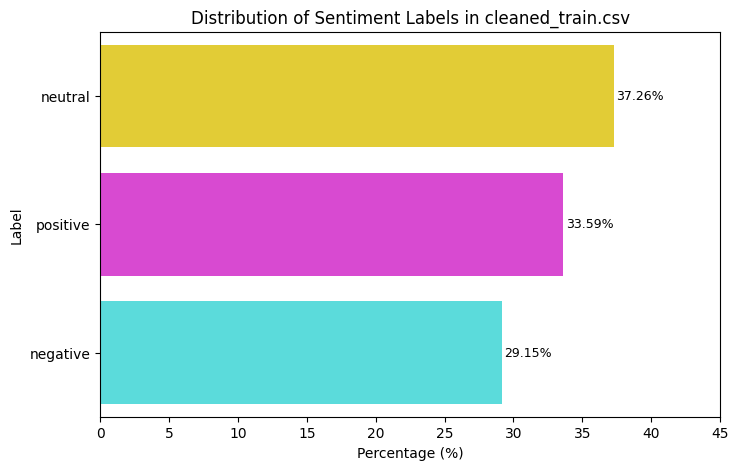

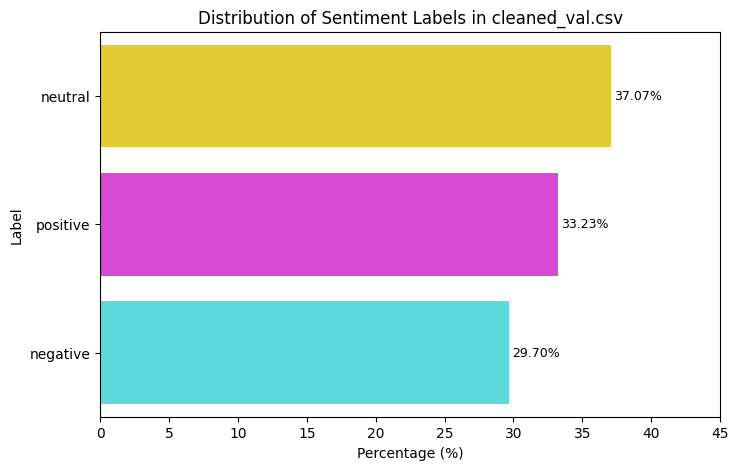

In [ ]:
# Old files
# files = ['Training Data/Sentiment Analysis Data/train_df.csv', 'Training Data/Sentiment Analysis Data/val_df.csv', 'Training Data/Sentiment Analysis Data/test_df.csv']

# New (cleaned+merged) files
files = ['Training Data/Sentiment Analysis Data/cleaned_train.csv', 'Training Data/Sentiment Analysis Data/cleaned_val.csv']

for file in files:
    visualize_sentiment_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

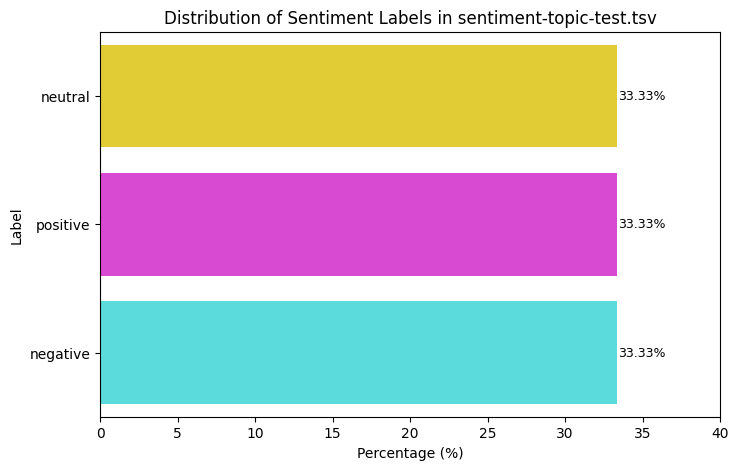

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

sentiment_counts = Counter(df['sentiment'])

total_labels = sum(sentiment_counts.values())
sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

ordered_labels = ["neutral", "positive", "negative"]
percentages = [sentiment_percentages[label] for label in ordered_labels]
color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8,5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Sentiment Labels in {filename}')
plt.show()

### VADER on Test Set

In [ ]:
nlp = spacy.load("en_core_web_sm")
vader_model = SentimentIntensityAnalyzer()

def vader_output_to_label(vader_output):
    """
    Convert VADER's compound score to sentiment labels.
    """
    compound = vader_output['compound']

    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    else:
        return 'positive'

# There is an option to turn on and off preprocessing of VADER input (preprocess=False/True).
# Without preprocessing, the performance increases, but it isn't a huge change in terms of number of misclassified sentences.
def run_vader(textual_unit, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False):
    """
    Run VADER on a sentence with optional lemmatization and POS filtering.

    Params:
        preprocess - enables or disables spaCy preprocessing before passing a sentence to VADER
    """
    if preprocess == True:
        doc = nlp(textual_unit)
        input_to_vader = []

        for sent in doc.sents:
            for token in sent:
                to_add = token.text
                if lemmatize:
                    to_add = token.lemma_
                    if to_add == '-PRON-':
                        to_add = token.text
                if parts_of_speech_to_consider:
                    if token.pos_ in parts_of_speech_to_consider:
                        input_to_vader.append(to_add)
                else:
                    input_to_vader.append(to_add)

        scores = vader_model.polarity_scores(' '.join(input_to_vader))

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("INPUT TO VADER:", input_to_vader)
            print("VADER OUTPUT:", scores)
    else:
        scores = vader_model.polarity_scores(textual_unit)

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("VADER OUTPUT:", scores)

    return scores

def evaluate_vader_on_testset(file_path, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False, print_report=False, misclassification_breakdown=False):
    """
    Run VADER on the test set and compare with ground truth sentiment labels.
    """
    df = pd.read_csv(file_path, delimiter="\t")

    # Dictionaries to store error counts and details for misclassified sentences
    misclassified_counts = {"positive": 0, "negative": 0, "neutral": 0}
    misclassified_sentences = {"positive": [], "negative": [], "neutral": []}

    actual_sentiments = df["sentiment"].tolist()
    sentences = df["sentence"].tolist()

    predicted_sentiments = []

    # Run VADER
    for i in range(len(sentences)):
        vader_output = run_vader(sentences[i], lemmatize=lemmatize, parts_of_speech_to_consider=parts_of_speech_to_consider, verbose=verbose, preprocess=preprocess)
        predicted_label = vader_output_to_label(vader_output)
        predicted_sentiments.append(predicted_label)

        true_label = actual_sentiments[i]

        # Check for misclassification
        if true_label != predicted_label:
            misclassified_counts[true_label] += 1
            misclassified_sentences[true_label].append((sentences[i], predicted_label, vader_output))

    # If the option is selected, show detailed misclassification breakdown
    if misclassification_breakdown == True:
        print("\nMisclassification Summary")
        print("-" * 50)
        for sentiment, count in misclassified_counts.items():
            print(f"{sentiment.capitalize()} misclassified: {count}")
        print("=" * 50)
        for sentiment, errors in misclassified_sentences.items():
            print(f"\nMisclassified {sentiment.capitalize()} Sentences")
            print("~" * 50)
            for sentence, predicted, vader_scores in errors:
                print(f"\nSentence: {sentence}")
                print(f"Expected: {sentiment}; Predicted: {predicted}")
                print(f"VADER Scores: {vader_scores}")
                print("*" * 50)

    # If the option is selected, show classification report
    if print_report == True:
        print("\nVADER Sentiment Analysis Performance:")
        print(classification_report(actual_sentiments, predicted_sentiments))

In [ ]:
# First print only classification report for better visibility
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None,
                                             verbose=False, preprocess=False, print_report=True, misclassification_breakdown=False)

# Run again with detailed breakdown of misclassifications for detailed analysis, if needed
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None,
                                             verbose=False, preprocess=False, print_report=False, misclassification_breakdown=True)


VADER Sentiment Analysis Performance:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.33      0.50      0.40         6
    positive       0.43      0.50      0.46         6

    accuracy                           0.33        18
   macro avg       0.25      0.33      0.29        18
weighted avg       0.25      0.33      0.29        18


Misclassification Summary
--------------------------------------------------
Positive misclassified: 3
Negative misclassified: 6
Neutral misclassified: 3

Misclassified Positive Sentences
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Sentence: The atmosphere at the stadium tonight was electric.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
**************************************************

Sentence: It had me hooked from the first chapter.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, '

### BERT on Test Set

In [11]:
# #if on colab import files
# from google.colab import files
# uploaded = files.upload()

In [12]:
#read cleaned data locally
#cleaned_train = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", delimiter=",")
#cleaned_val = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", delimiter=",")
#sentiment_test = pd.read_csv("Test Data/sentiment-topic-test.tsv", delimiter="\t")

#read cleaned data on colab
cleaned_train = pd.read_csv("cleaned_train.csv", delimiter=",")
cleaned_val = pd.read_csv("cleaned_val.csv", delimiter=",")
sentiment_test = pd.read_csv("sentiment-topic-test.tsv", delimiter="\t")


#rename columns so they match across all datasets
cleaned_train = cleaned_train[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
cleaned_val = cleaned_val[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
sentiment_test = sentiment_test[['sentence', 'sentiment']].rename(columns={'sentence': 'text', 'sentiment': 'labels'})

#BERT requires numerical labels --> change to 0/1/2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

cleaned_train['labels'] = cleaned_train['labels'].map(label_map)
cleaned_val['labels'] = cleaned_val['labels'].map(label_map)
sentiment_test['labels'] = sentiment_test['labels'].map(label_map)


In [22]:
#defining model's configuration
model_args = ClassificationArgs()

model_args.overwrite_output_dir = True  #overwrite any saved models in the output directory
model_args.evaluate_during_training = True  #evaluate during training
model_args.num_train_epochs = 10
model_args.train_batch_size = 16
model_args.learning_rate = 4e-6
model_args.max_seq_length = 256
model_args.fp16 = False


model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 2
model_args.evaluate_during_training_steps = 32


steps_per_epoch = int(np.ceil(len(cleaned_train) / float(model_args.train_batch_size)))
print(f'Each epoch will have {steps_per_epoch} steps.')

Each epoch will have 2278 steps.


In [23]:
#load the model
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
_, history = model.train_model(cleaned_train, eval_df=cleaned_val)

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/2278 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

# 3. Topic Classification

### Training & Validation Sets

In [4]:
DetectorFactory.seed = 0  # Ensures consistent language detection

# Load dataset
train_df_tm = pd.read_csv("Training Data/Topic Classification Data/topic_train.csv")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

# Function to remove all common emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(r"""
        (:|;|=|X|8)  
        (-|')?       
        (\)|D|P|O|o|\(|/|\\|\*|3|\||\]|\[)
        |<3          
        |¯\\_\(ツ\)_/¯ 
        |o_O|O_o|o.o|O.O  
        |:-?[\[\]{}()<>]
        |:\'\(|:\'\)  
    """, re.VERBOSE)
    return emoticon_pattern.sub('', text)

# Function to removes all punctuation, keeps only words & numbers
def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\s+', ' ', text).strip() 
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
    return text

# Function to count words correctly
def count_words(text):
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text)  # Only count words with at least 2 letters
    return len(words)

# Function to remove surrounding quotes
def remove_surrounding_quotes(text):
    return text.strip("'\"")

# Function to check if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, assume non-English

# Function to generate n-grams (L-LDA assumes multi-word expressions are meaningful)
def generate_ngrams(text, n=2):
    tokens = text.split()
    bigrams = ['_'.join(gram) for gram in ngrams(tokens, n)]
    return text + " " + " ".join(bigrams)  

# **Unified Preprocessing Function**
def preprocess_text(text):
    text = remove_emojis(text)  
    text = remove_emoticons(text)  
    text = clean_text(text) 
    text = remove_surrounding_quotes(text)  
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    text = " ".join(tokens)
    return generate_ngrams(text)  # Add bigrams

In [ ]:
# Apply Preprocessing Pipeline
train_tm_clean = train_df_tm.copy()
train_tm_clean['review'] = train_tm_clean['review'].astype(str)
train_tm_clean['review'] = train_tm_clean['review'].map(preprocess_text, na_action='ignore')

# Remove non-English reviews
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(is_english)]

# Remove not meaningful reviews (reviews with less than 3 words)
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(count_words) > 3]

# Reset index after filtering
train_tm_clean.reset_index(drop=True, inplace=True)

# Save cleaned dataset in the same Training Data folder
train_tm_clean.to_csv("Training Data/Topic Classification Data/train_tm_clean.csv", index=False)

#### Distribution Analysis

In [7]:
def visualize_topic_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)

    topic_counts = Counter(df['label'])

    total_labels = sum(topic_counts.values())
    topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

    ordered_labels = ["sports", "movie", "book"]
    percentages = [topic_percentages[label] for label in ordered_labels]
    color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
    colors = [color_map[label] for label in ordered_labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Topic Labels in {filename}')
    plt.show()

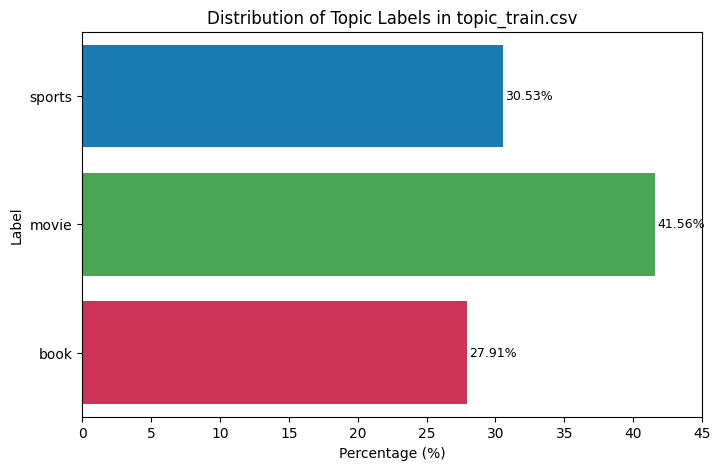

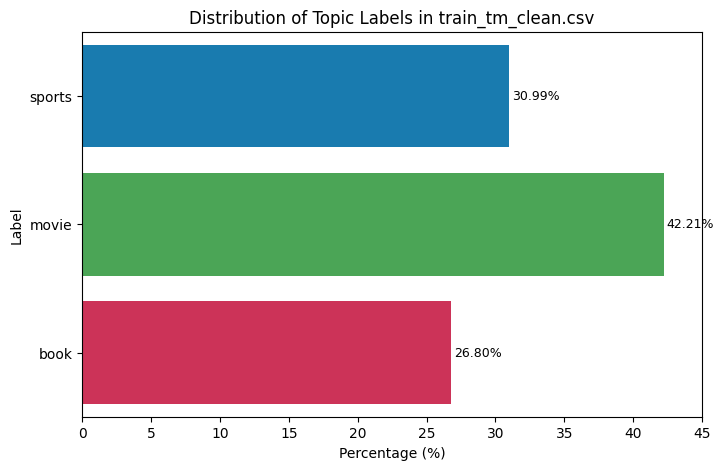

In [10]:
# This dataset did not come split; therefore, plot the whole thing here, and we can call the vis function for each split after, if we want to plot each part
files = ['Training Data/Topic Classification Data/topic_train.csv', 'Training Data/Topic Classification Data/train_tm_clean.csv']

for file in files:
    visualize_topic_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

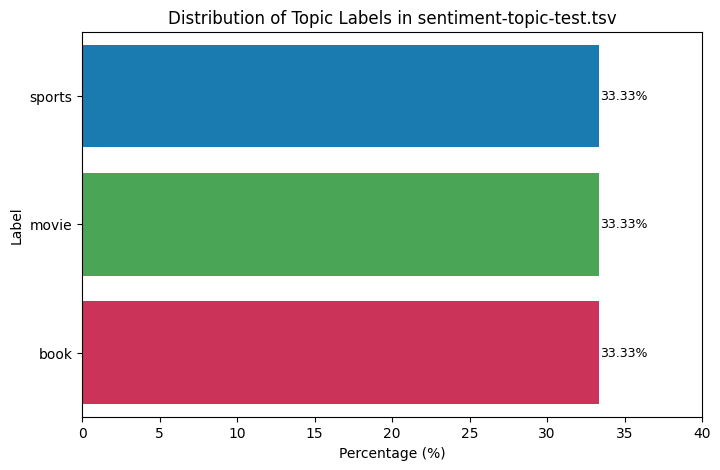

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

topic_counts = Counter(df['topic'])

total_labels = sum(topic_counts.values())
topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

ordered_labels = ["sports", "movie", "book"]
percentages = [topic_percentages[label] for label in ordered_labels]
color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8, 5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Topic Labels in {filename}')
plt.show()

### Feature Engineering

### Model Training

In [ ]:
train_df = pd.read_csv('Training Data/Topic Classification Data/train_tm_clean.csv')
train_df = train_df.drop(columns=["Unnamed: 0"])

# Mapping text labels to numerical IDs for topic modeling
# The L-LDA paper assigns documents to a fixed set of topics, so we need to convert topic labels into numerical values.
unique_labels = sorted(train_df["label"].unique())  
label_to_id = {label: i for i, label in enumerate(unique_labels)}  
train_df["label_id"] = train_df["label"].map(label_to_id) 

# Extracting meaningful words from text
# According to the L-LDA paper, important topic words are typically nouns and verbs.
# We'll filter out only these parts of speech to improve topic-word distribution.
# Additionally, we'll use n-grams to capture multi-word topic terms and apply TF-IDF weighting
# instead of raw word counts to avoid giving too much importance to common words.

def pos_filter(text):
    """ 
    Keep only nouns and verbs, assuming they carry the most topic related information 
    """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    meaningful_words = [word for word, pos in tagged if pos.startswith("N") or pos.startswith("V")]
    return " ".join(meaningful_words)

In [6]:
# Apply POS filtering
train_df["review"] = train_df["review"].apply(pos_filter)

In [7]:
# Transforming text data into numerical features using TF-IDF
# The original L-LDA model relies on a simple bag-of-words (BoW) approach, 
# but we enhance it by applying TF-IDF. This helps downweight common words 
# and gives more importance to informative terms, improving topic separation.
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  # Includes both single words and bigrams
X = vectorizer.fit_transform(train_df["review"])  


In [8]:
# Adjusting for imbalanced topic distribution
# The L-LDA model assumes topics are evenly distributed, but in practice, some topics may be much rarer than others.
# To prevent bias toward dominant topics, we compute class weights, ensuring that minority topics get appropriate importance.
class_weights = compute_class_weight("balanced", classes=np.unique(train_df["label_id"]), y=train_df["label_id"])
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [9]:
# Splitting data into training and validation sets while maintaining label distribution
# Since some topics may be less frequent than others, we use stratified sampling to ensure that 
# each label is proportionally represented in both the training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(
    X, train_df["label_id"], test_size=0.2, stratify=train_df["label_id"], random_state=8
)


### Model Evaluation on the Test Set